In [33]:
import pandas as pd
import numpy as np

import math
from collections import defaultdict
from collections import Counter
from typing import Dict, Any
from scipy.spatial.distance import cdist

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt

In [44]:
data = pd.read_csv('data/famcs_students.csv')
data.head()

,cource,group,stream,sex,age,ss,interest,os,weekend_study,bad_sleep,...,social,sport,miss,study_form,foot_size,eye_color,score,retake,hostel,literature
0,4,11,Прикладная информатика,М,20.0,Нет,Математика,MacOS,Да,Да,...,Экстраверт,"Редко, легкая физкультура",3.0,Бюджет,48.0,Карие,9.2,0,"Нет, я из Минска",Да
1,4,11,Прикладная информатика,Ж,20.0,Нет,Программирование,MacOS,Нет,Нет,...,Экстраверт,"Да, я спортсмен",5.0,Бюджет,39.0,Зеленые,8.8,0,"Нет, я из Минска",Да
2,4,11,Прикладная информатика,Ж,19.0,Нет,Программирование,MacOS,Да,Нет,...,Экстраверт,Вообще нет,10.0,Бюджет,41.0,Карие,8.8,0,"Нет, я из Минска",Да
3,4,11,Прикладная информатика,Ж,20.0,Нет,Математика,MacOS,Да,Да,...,Экстраверт,"Да, я спортсмен",3.0,Бюджет,36.0,Карие,8.8,0,"Нет, я из Минска",Да
4,4,11,Прикладная информатика,М,20.0,Нет,Математика,Windows,Да,Нет,...,Интроверт,Вообще нет,1.0,Бюджет,46.0,Зеленые,9.0,0,"Нет, я из Минска",Да


In [45]:
binary_cols = ['ss', 'interest', 'weekend_study', 'bad_sleep', 'glasses', 'anime', 'study_form', 'literature']

N = 2
target_col = binary_cols[N % 8]
print(target_col)

weekend_study


In [46]:
data.nunique()

cource              2
group               8
stream              3
sex                 2
age                 6
ss                  2
interest            2
os                  3
weekend_study       2
bad_sleep           2
glasses             2
work_experience     4
ai                 13
height             40
anime               2
social              3
sport               3
miss               22
study_form          2
foot_size          18
eye_color           4
score              42
retake              3
hostel              3
literature          2
dtype: int64

In [47]:
obj_cols = ['sex', 'ss', 'interest', 'os', 'weekend_study', 
'bad_sleep', 'glasses', 'work_experience', 'anime', 'social', 'sport', 'study_form', 'eye_color', 'retake', 'hostel', 'literature', 'cource', 'group', 'stream']

In [48]:
data['weekend_study'] = data['weekend_study'].map({'Да': 1, 'Нет': 0}).astype(int)

In [49]:
for col in obj_cols:
    if col == target_col:
        continue
    print(data.groupby(col)[target_col].mean())
    print()


sex
Ж    0.785714
М    0.776471
Name: weekend_study, dtype: float64

ss
Да     1.000000
Нет    0.752212
Name: weekend_study, dtype: float64

interest
Математика          0.833333
Программирование    0.766990
Name: weekend_study, dtype: float64

os
Linux      0.800000
MacOS      0.806452
Windows    0.763158
Name: weekend_study, dtype: float64

bad_sleep
Да     0.811111
Нет    0.702703
Name: weekend_study, dtype: float64

glasses
Да     0.764706
Нет    0.796610
Name: weekend_study, dtype: float64

work_experience
1-2 года       0.735294
Меньше года    0.789474
Не работаю     0.791667
более 2 лет    0.857143
Name: weekend_study, dtype: float64

anime
Да     0.777778
Нет    0.780822
Name: weekend_study, dtype: float64

social
Интроверт     0.741935
Социофоб      0.875000
Экстраверт    0.807018
Name: weekend_study, dtype: float64

sport
Вообще нет                   0.791667
Да, я спортсмен              0.794872
Редко, легкая физкультура    0.765625
Name: weekend_study, dtype: float64

study

In [53]:
multiclass_cols = ['work_experience', 'social', 'sport', 'retake', 'hostel', 'group', 'stream']

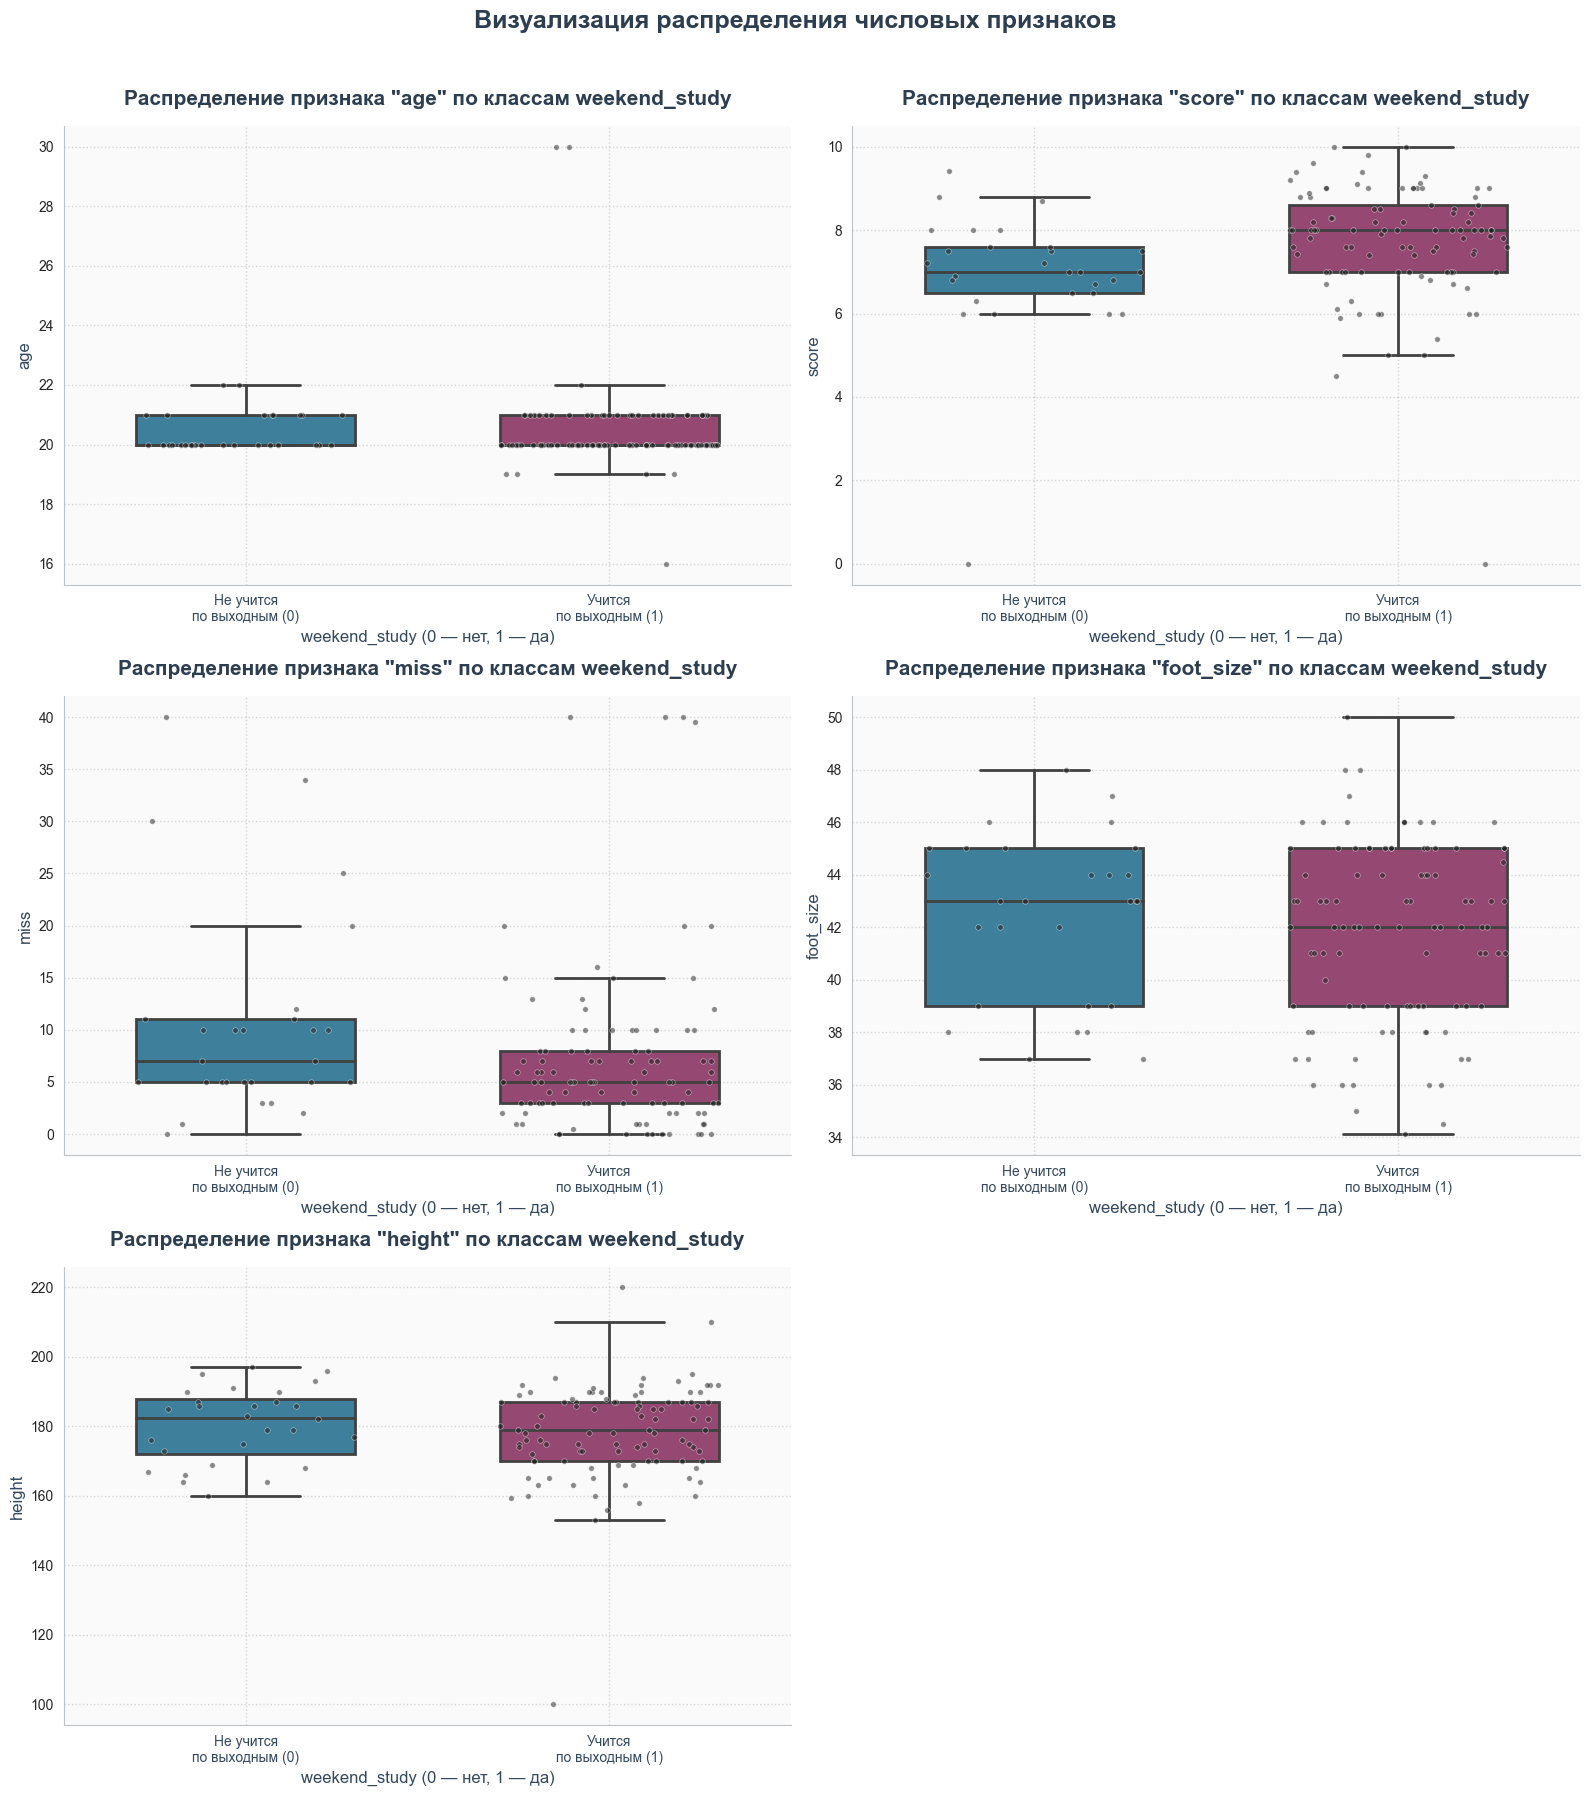

In [51]:
possible_numerical = ['age', 'score', 'miss', 'foot_size', 'height']
numerical_features = [col for col in possible_numerical if col in data.columns]

viz_df = data[numerical_features + [target_col]].copy()

n_features = len(numerical_features)
n_cols = 2
n_rows = (n_features + 1) // n_cols

# Настройка стиля
sns.set_style("darkgrid")
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 6 * n_rows), facecolor='white')
axes = axes.flatten() if n_features > 1 else [axes]

# Цветовая палитра
colors = ['#2E86AB', '#A23B72']  # Синий и розовый

for i, feature in enumerate(numerical_features):
    ax = axes[i]
    
    # Boxplot с улучшенным стилем
    box_plot = sns.boxplot(
        data=viz_df,
        x=target_col,
        y=feature,
        palette=colors,
        width=0.6,
        linewidth=2,
        ax=ax,
        showfliers=False  # Скрываем выбросы, так как используем stripplot
    )
    
    # Улучшенный stripplot
    sns.stripplot(
        data=viz_df,
        x=target_col,
        y=feature,
        color='#1A1A1A',
        alpha=0.5,
        size=4,
        jitter=0.3,
        edgecolor='white',
        linewidth=0.5,
        ax=ax
    )
    
    # Оформление заголовка и подписей
    ax.set_title(
        f'Распределение признака "{feature}" по классам {target_col}',
        fontsize=15,
        fontweight='bold',
        pad=15,
        color='#2C3E50'
    )
    ax.set_xlabel(
        f'{target_col} (0 — нет, 1 — да)',
        fontsize=12,
        fontweight='medium',
        color='#34495E'
    )
    ax.set_ylabel(
        feature,
        fontsize=12,
        fontweight='medium',
        color='#34495E'
    )
    
    # Улучшенная сетка
    ax.grid(True, linestyle=':', alpha=0.3, linewidth=1, color='gray')
    ax.set_axisbelow(True)
    
    # Оформление фона
    ax.set_facecolor('#FAFAFA')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('#BDC3C7')
    ax.spines['bottom'].set_color('#BDC3C7')
    
    # Улучшение подписей на оси X
    ax.set_xticklabels(['Не учится\nпо выходным (0)', 'Учится\nпо выходным (1)'], 
                        fontsize=10, color='#34495E')

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.suptitle(
    'Визуализация распределения числовых признаков',
    fontsize=18,
    fontweight='bold',
    y=0.995,
    color='#2C3E50'
)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

In [54]:
cols = [
    'ss', 'interest', 'bad_sleep', 
    'work_experience', 'social', 'study_form', 
    'retake', 'hostel', 'cource', 
    'group', 'stream', 'score', 'miss'
]

data = pd.read_csv('data/famcs_students.csv')
data = data[cols + [target_col]]
data[target_col] = data[target_col].map({'Да': 1, 'Нет': 0}).astype(int)

# обработка бинарных признаков
data['ss'] = data['ss'].map({'Да': 1, 'Нет': 0}).astype(int)
data['bad_sleep'] = data['bad_sleep'].map({'Да': 1, 'Нет': 0}).astype(int)
data['study_form'] = data['study_form'].map({'Бюджет': 1, 'Платная': 0}).astype(int)
data['interest'] = data['interest'].map({'Математика': 1, 'Программирование': 0}).astype(int)

# многоклассовая обработка
data = pd.get_dummies(data, columns=[col for col in multiclass_cols if col in cols]).astype(int)
data = data.drop(columns=['work_experience_Не работаю', 'social_Социофоб', 'retake_0', 'hostel_Нет, я из регионов', 'group_1', 'stream_Информатика'])


X = data.drop(columns=[target_col])
y = data[target_col]

scaler = StandardScaler()
numeric_cols = ['age', 'miss', 'score']
numeric_cols_selected = [col for col in numeric_cols if col in cols]
X[numeric_cols_selected] = scaler.fit_transform(X[numeric_cols_selected])

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

## Тривиальный классификатор

In [56]:
most_frequent_class = y_train.mode()[0]
y_pred_trivial = [most_frequent_class] * len(y_test)

## Наивный байесовский классификатор

### Теоретическая база наивного байесовского классификатора

#### 1. Теорема Байеса

Основная формула теоремы Байеса:

$$P(y|x_1, x_2, ..., x_n) = \frac{P(y) \cdot P(x_1, x_2, ..., x_n|y)}{P(x_1, x_2, ..., x_n)}$$

где:
- $P(y|x_1, x_2, ..., x_n)$ — апостериорная вероятность класса $y$ при заданных признаках
- $P(y)$ — априорная вероятность класса $y$
- $P(x_1, x_2, ..., x_n|y)$ — правдоподобие (вероятность признаков при заданном классе)
- $P(x_1, x_2, ..., x_n)$ — нормализующая константа (не зависит от класса)

#### 2. Наивное предположение о независимости

Ключевое упрощение: признаки условно независимы при заданном классе:

$$P(x_1, x_2, ..., x_n|y) = \prod_{i=1}^{n} P(x_i|y)$$

Это позволяет упростить вычисления, хотя в реальности признаки часто зависимы.

#### 3. Формула классификации

После применения наивного предположения, апостериорная вероятность принимает вид:

$$P(y|x_1, x_2, ..., x_n) = \frac{P(y) \prod_{i=1}^{n} P(x_i|y)}{P(x_1, x_2, ..., x_n)}$$

Поскольку знаменатель одинаков для всех классов, классификация выполняется по правилу:

$$\hat{y} = \arg\max_y P(y) \prod_{i=1}^{n} P(x_i|y)$$

#### 4. Bernoulli Naive Bayes (для бинарных признаков)

В данной реализации используется вариант для бинарных признаков, где каждый признак $x_i \in \{0, 1\}$.

**Оценка вероятностей:**
- Априорная вероятность класса: $P(y) = \frac{N_y}{N}$, где $N_y$ — количество объектов класса $y$, $N$ — общее количество объектов
- Условная вероятность признака: $P(x_i=1|y) = \frac{N_{i,y}}{N_y}$, где $N_{i,y}$ — количество объектов класса $y$ с $x_i=1$

**Сглаживание Лапласа:**
Для избежания нулевых вероятностей (когда признак не встречается в классе) применяется сглаживание:

$$P(x_i=1|y) = \frac{N_{i,y} + \alpha}{N_y + 2\alpha}$$

где $\alpha$ — параметр сглаживания (обычно $\alpha = 1$).

#### 5. Численная стабильность

Для предотвращения переполнения при умножении малых вероятностей используются логарифмы:

$$\log P(y|x_1, ..., x_n) = \log P(y) + \sum_{i=1}^{n} \log P(x_i|y) - \log P(x_1, ..., x_n)$$

Поскольку знаменатель не влияет на выбор класса, классификация выполняется по:

$$\hat{y} = \arg\max_y \left[ \log P(y) + \sum_{i=1}^{n} \log P(x_i|y) \right]$$

In [57]:
class BernoulliNaiveBayes:
    def __init__(self, alpha=1.0):
        self.alpha = alpha

    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)
        self.classes_ = np.unique(y)
        n_samples, n_features = X.shape

        self.class_log_prior_ = {}
        self.feature_log_prob_ = {}

        for c in self.classes_:
            X_c = X[y == c]
            n_c = X_c.shape[0]

            # log P(class)
            self.class_log_prior_[c] = np.log(n_c / n_samples)

            # P(feature=1 | class) с Laplace smoothing
            # (count + alpha) / (n_c + 2*alpha)
            prob = (X_c.sum(axis=0) + self.alpha) / (n_c + 2 * self.alpha)
            prob = np.clip(prob, 1e-10, 1 - 1e-10)

            self.feature_log_prob_[c] = np.log(prob), np.log(1 - prob)

    def predict_proba(self, X):
        X = np.array(X)
        n_samples = X.shape[0]
        class_probs = np.zeros((n_samples, len(self.classes_)))

        for idx, c in enumerate(self.classes_):
            log_prob_pos, log_prob_neg = self.feature_log_prob_[c]
            # X * log(p) + (1 - X) * log(1 - p)
            log_likelihood = np.sum(X * log_prob_pos + (1 - X) * log_prob_neg, axis=1)
            class_probs[:, idx] = self.class_log_prior_[c] + log_likelihood

        log_prob_norm = class_probs - np.max(class_probs, axis=1, keepdims=True)
        prob = np.exp(log_prob_norm)
        return prob / prob.sum(axis=1, keepdims=True)

    def predict(self, X):
        return self.classes_[np.argmax(self.predict_proba(X), axis=1)]

In [58]:
nb = BernoulliNaiveBayes()
nb.fit(X_train[[f for f in binary_cols if f != target_col and f in cols]].values, y_train.values)
y_pred_nb = nb.predict(X_test[[f for f in binary_cols if f != target_col and f in cols]].values)
y_proba_nb = nb.predict_proba(X_test[[f for f in binary_cols if f != target_col and f in cols]].values)[:, 1]

## 2. Метод k-ближайших соседей

In [59]:
class KNearestNeighbors:
    def __init__(self, k=5):
        self.k = k

    def fit(self, X, y):
        self.X_train = np.array(X)
        self.y_train = np.array(y) 

    def predict(self, X):
        X = np.array(X)
        distances = cdist(X, self.X_train, metric='euclidean') 
        k_indices = np.argpartition(distances, self.k, axis=1)[:, :self.k]
        k_nearest_labels = self.y_train[k_indices]  
        predictions = []
        for row in k_nearest_labels:
            values, counts = np.unique(row, return_counts=True)
            predictions.append(values[np.argmax(counts)])
        return np.array(predictions)

In [60]:
best_k, best_score = 1, -1
from sklearn.metrics import f1_score

for k in range(1, 21):
    knn = KNearestNeighbors(k=k)
    knn.fit(X_train.values, y_train.values)
    y_pred_val = knn.predict(X_val.values)
    score = f1_score(y_val, y_pred_val, zero_division=0)
    if score > best_score:
        best_k, best_score = k, score

print(f'Best k: {best_k}')

knn_best = KNearestNeighbors(k=best_k)
knn_best.fit(X_train.values, y_train.values)
y_pred_knn = knn_best.predict(X_test.values)

Best k: 15


## 3. Логистическая регрессия


#### Функция потерь (Log Loss)

Для обучения модели используется функция потерь, основанная на максимизации правдоподобия. Для бинарной классификации это бинарная кросс-энтропия:

$$L(\mathbf{w}, b) = -\frac{1}{N} \sum_{i=1}^{N} \left[ y_i \log(\hat{y}_i) + (1-y_i) \log(1-\hat{y}_i) \right]$$

где:
- $N$ — количество объектов
- $y_i \in \{0, 1\}$ — истинная метка класса
- $\hat{y}_i = \sigma(\mathbf{w}^T \mathbf{x}_i + b)$ — предсказанная вероятность

$$\hat{y} = \begin{cases} 
1 & \text{если } P(y=1|\mathbf{x}) \geq \theta \\
0 & \text{если } P(y=1|\mathbf{x}) < \theta
\end{cases}$$

где $\theta$ — порог классификации (обычно $\theta = 0.5$). Порог можно настраивать для балансировки между precision и recall.

In [61]:
class LogisticRegressionScratch:
    def __init__(self, lr=0.01, n_iters=1000):
        self.lr = lr
        self.n_iters = n_iters

    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-np.clip(z, -500, 500)))

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        for _ in range(self.n_iters):
            linear_pred = np.dot(X, self.weights) + self.bias
            predictions = self._sigmoid(linear_pred)

            dw = (1 / n_samples) * np.dot(X.T, (predictions - y))
            db = (1 / n_samples) * np.sum(predictions - y)

            self.weights -= self.lr * dw
            self.bias -= self.lr * db

    def predict_proba(self, X):
        linear_pred = np.dot(X, self.weights) + self.bias
        return self._sigmoid(linear_pred)

    def predict(self, X, threshold=0.5):
        return (self.predict_proba(X) >= threshold).astype(int)

In [71]:
lr_model = LogisticRegressionScratch(lr=0.1, n_iters=2000)
lr_model.fit(X_train.values, y_train.values)

y_val_proba = lr_model.predict_proba(X_val.values)

thresholds = np.arange(0.4, 1.0, 0.01)
best_f1, best_thresh = 0, 0.5

for t in thresholds:
    y_val_pred = (y_val_proba >= t).astype(int)
    f1 = f1_score(y_val, y_val_pred, zero_division=0)
    if f1 > best_f1:
        best_f1, best_thresh = f1, t

y_pred_lr = lr_model.predict(X_test.values, threshold=0.71)
y_proba_lr = lr_model.predict_proba(X_test.values)

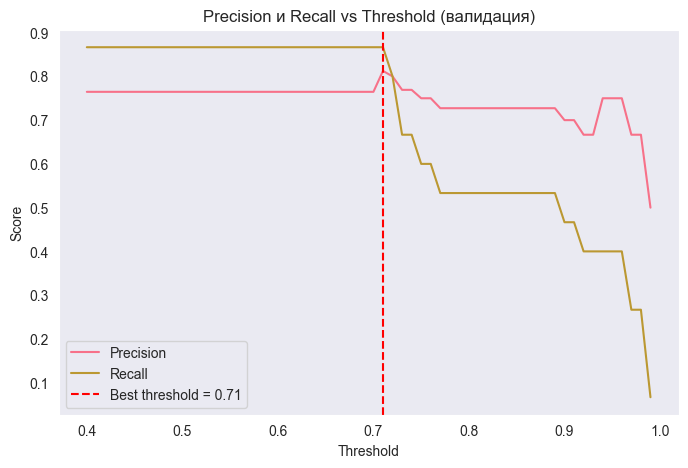

In [72]:
precisions, recalls = [], []
for t in thresholds:
    y_v_pred = (y_val_proba >= t).astype(int)
    precisions.append(precision_score(y_val, y_v_pred, zero_division=0))
    recalls.append(recall_score(y_val, y_v_pred, zero_division=0))

plt.figure(figsize=(8,5))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.axvline(best_thresh, color='red', linestyle='--', label=f'Best threshold = {best_thresh:.2f}')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.title('Precision и Recall vs Threshold (валидация)')
plt.grid()
plt.show()

## Оценка качества

In [73]:
def evaluate_model(y_true, y_pred, y_proba=None):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    auc = roc_auc_score(y_true, y_proba) if y_proba is not None else np.nan
    cm = confusion_matrix(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return {'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'ROC-AUC': auc, 'Confusion Matrix': cm, 'F1-score': f1}

In [74]:
results = {}

results['Trivial'] = evaluate_model(y_test, y_pred_trivial)

results['Naive Bayes'] = evaluate_model(y_test, y_pred_nb, y_proba_nb)

results['kNN'] = evaluate_model(y_test, y_pred_knn)

results['Logistic Regression'] = evaluate_model(y_test, y_pred_lr, y_proba_lr)

📊 Таблица метрик качества моделей:

                     Accuracy  Precision  Recall  ROC-AUC  F1-score
Модель                                                             
Trivial                  0.75       0.75     1.0      NaN    0.8571
Naive Bayes              0.75       0.75     1.0   0.6667    0.8571
kNN                      0.75       0.75     1.0      NaN    0.8571
Logistic Regression      0.65       0.75     0.8   0.6933    0.7742


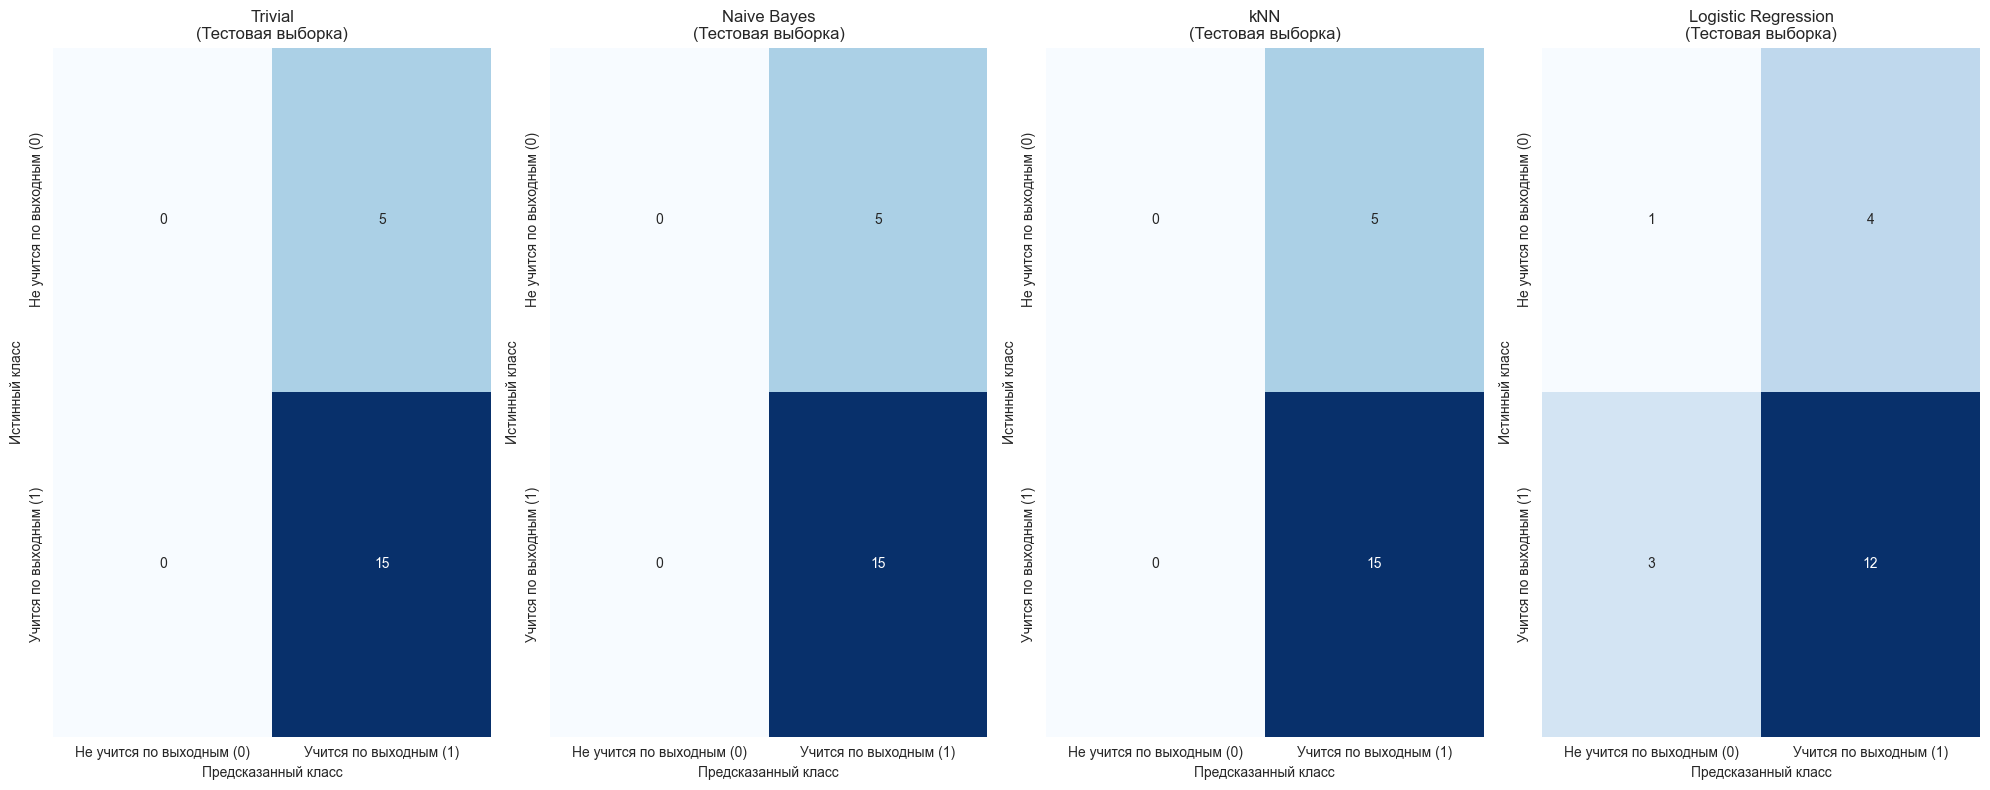

In [75]:
metrics_list = []
for name, metrics in results.items():
    row = {'Модель': name}
    for k, v in metrics.items():
        if k != 'Confusion Matrix':
            row[k] = v
    metrics_list.append(row)

df_metrics = pd.DataFrame(metrics_list).set_index('Модель')
df_metrics = df_metrics.round(4)
print("📊 Таблица метрик качества моделей:\n")
print(df_metrics)

n_models = len(results)
fig, axes = plt.subplots(1, n_models, figsize=(5 * n_models, 8))
if n_models == 1:
    axes = [axes]

for ax, (name, metrics) in zip(axes, results.items()):
    cm = metrics['Confusion Matrix']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax,
                xticklabels=['Не учится по выходным (0)', 'Учится по выходным (1)'],
                yticklabels=['Не учится по выходным (0)', 'Учится по выходным (1)'])
    ax.set_title(f'{name}\n(Тестовая выборка)', fontsize=12)
    ax.set_ylabel('Истинный класс')
    ax.set_xlabel('Предсказанный класс')

plt.tight_layout()
plt.show()